### `Creating User-Defined Table Functions (UDTFs) for DataFrames in Python`

`user-defined table function (UDTF)`
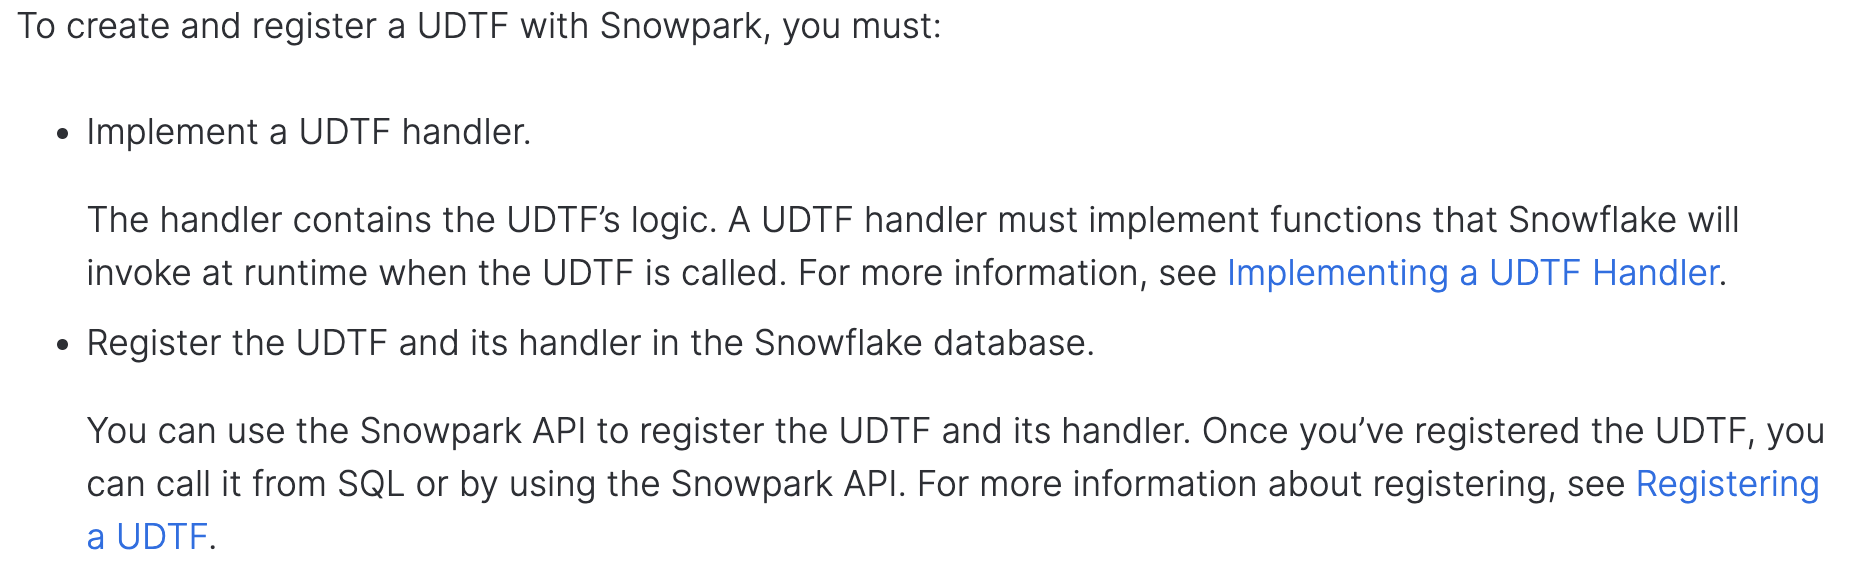

`Implementing a UDTF Handler`
- Introduction to Python UDFs: https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-introduction
- Writing a UDTF in Python: https://docs.snowflake.com/en/developer-guide/udf/python/udf-python-tabular-function

`Registering a UDTF`
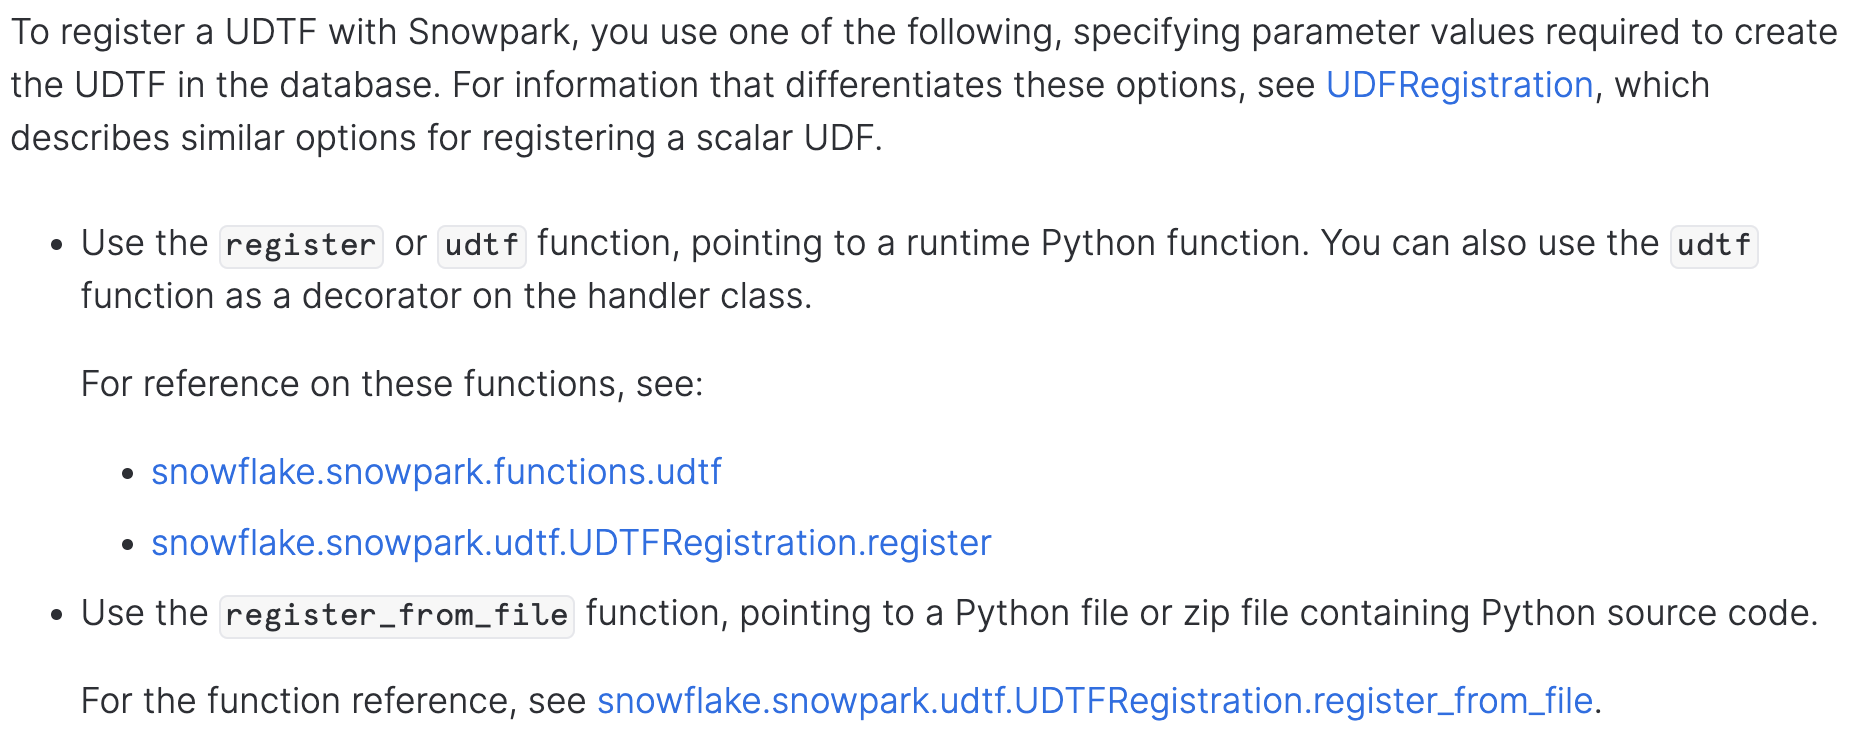

- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.udf.UDFRegistration
- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.udtf.UDTFRegistration.register_from_file

`Defining a UDTF’s Input Types and Output Schema`

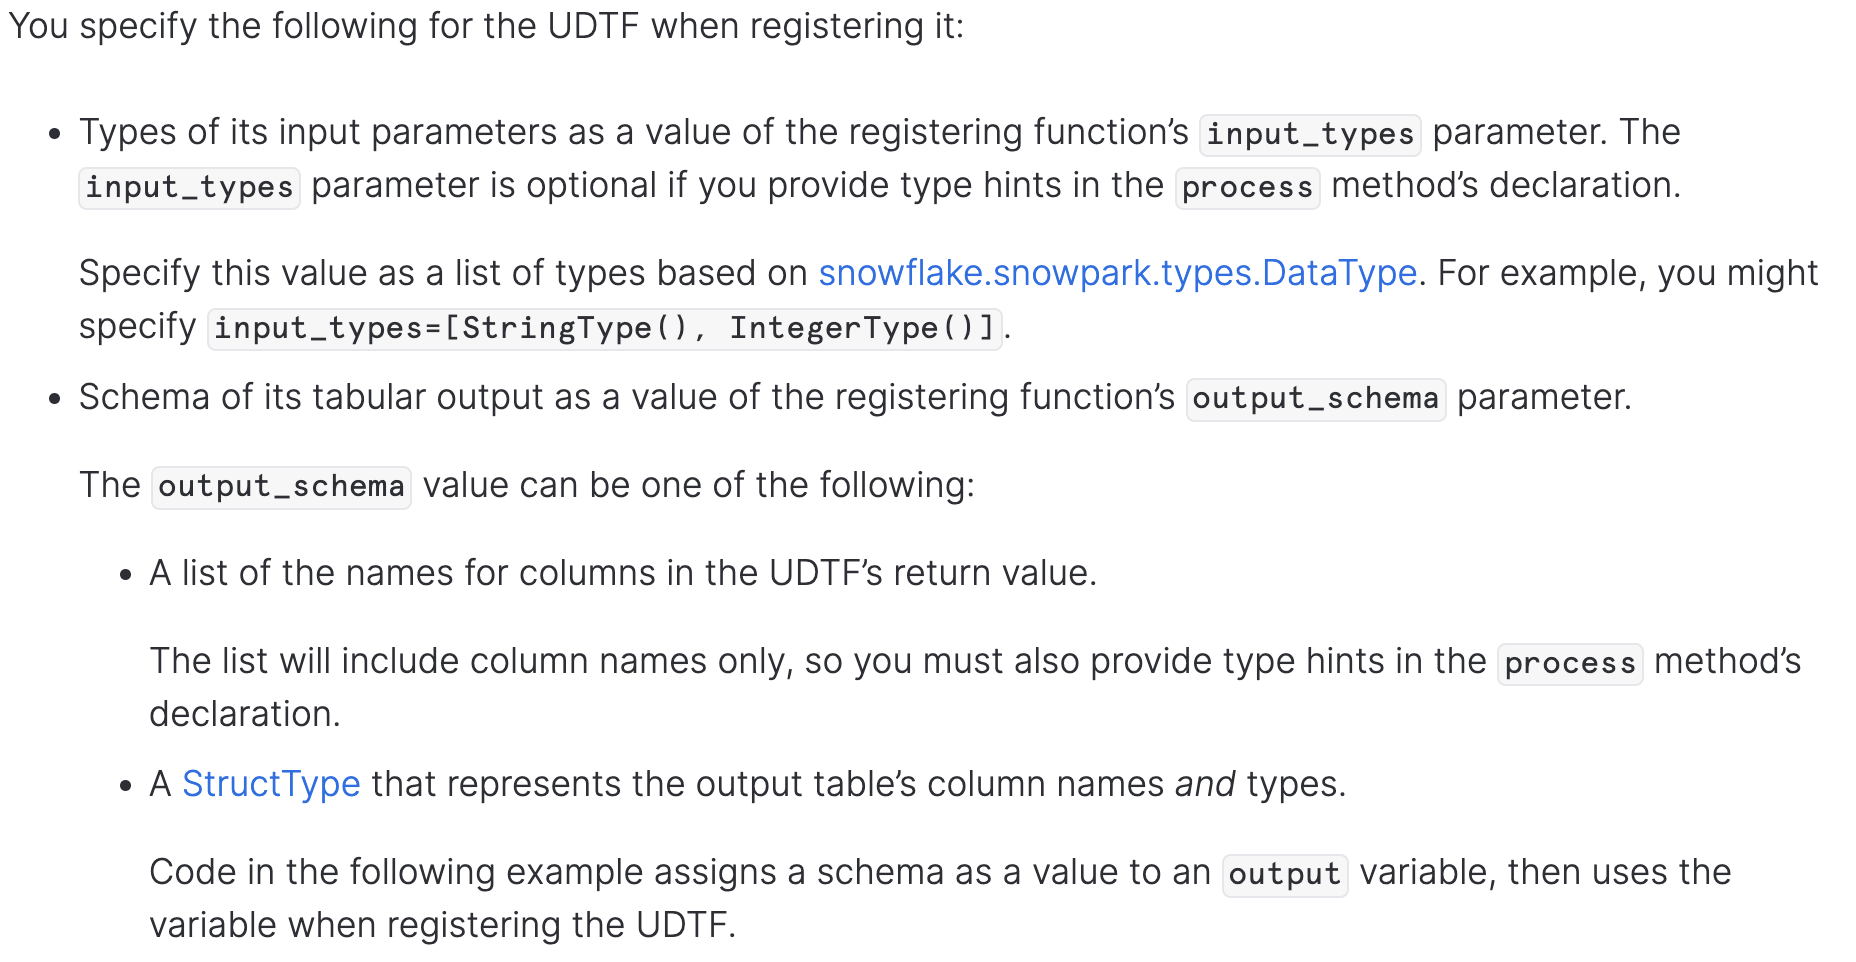

Code in the following example assigns a schema as a value to an output variable, then uses the variable when registering the UDTF.

In [1]:
import os
import json
import pandas as pd
import configparser
from snowflake.snowpark import Session
from copy import copy
from snowflake.snowpark import Row
from snowflake.snowpark.functions import col, lit, sql_expr, get, get_path, udf, udtf, table_function
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, DecimalType, LongType
from snowflake.snowpark.exceptions import SnowparkJoinException, SnowparkSQLException
from snowflake.snowpark.files import SnowflakeFile

# Read snowflake credentials securely
config = configparser.ConfigParser()
config.read('credentials.cfg')

# Create a Python dictionary (dict) containing the names and values of the parameters for connecting to Snowflake.
#connection_parameters = dict(
#   account   =  config['SNOWPARKAZ']['SNOWFLAKE_ACCOUNT'],
#   user      =  config['SNOWPARKAZ']['SNOWFLAKE_USER'],
#   password  =  config['SNOWPARKAZ']['SNOWFLAKE_PASSWORD'],
#   role      =  config['SNOWPARKAZ']['SNOWFLAKE_ROLE'],  # optional
#   warehouse =  config['SNOWPARKAZ']['SNOWFLAKE_WAREHOUSE'],  # optional
#   database  =  config['SNOWPARKAZ']['SNOWFLAKE_DATABASE'],  # optional
#   schema    =  config['SNOWPARKAZ']['SNOWFLAKE_SCHEMA'],  # optional
#)

connection_parameters = dict(
   account   =  config['SNOWPARKAWS']['SNOWFLAKE_ACCOUNT'],
   user      =  config['SNOWPARKAWS']['SNOWFLAKE_USER'],
   password  =  config['SNOWPARKAWS']['SNOWFLAKE_PASSWORD'],
   role      =  config['SNOWPARKAWS']['SNOWFLAKE_ROLE'],  # optional
   warehouse =  config['SNOWPARKAWS']['SNOWFLAKE_WAREHOUSE'],  # optional
   database  =  config['SNOWPARKAWS']['SNOWFLAKE_DATABASE'],  # optional
   schema    =  config['SNOWPARKAWS']['SNOWFLAKE_SCHEMA'],  # optional
)

# Pass this dictionary to the Session.builder.configs method to return a builder object that has these connection parameters.
# Call the create method of the builder to establish the session.
session = Session.builder.configs(connection_parameters).create()

In [2]:
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, FloatType
from snowflake.snowpark.functions import udtf, table_function

schema = StructType([StructField("symbol", StringType())
                    ,StructField("cost", IntegerType())
                    ])

@udtf(output_schema=schema, input_types=[StringType(), IntegerType(), FloatType()], stage_location='@SF_UDF_INT_STG', is_permanent=True, name="StockSale", replace=True)
class StockSale:
    def process(self, symbol, quantity, price):
        cost = quantity * price
        yield (symbol, cost)

In [14]:
# Registering a UDTF with the udtf Function
# Register the function.
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType, FloatType
from snowflake.snowpark.functions import udtf, lit, table_function

class GeneratorUDTF:
    def process(self, n):
        for i in range(n):
            yield(i,)

generator_udtf = udtf(GeneratorUDTF, output_schema=StructType([StructField("number", IntegerType())]), input_types=[IntegerType()])

In [15]:
# Call the function.
session.table_function(generator_udtf(lit(5))).show() # Query it by calling it

------------
|"NUMBER"  |
------------
|0         |
|1         |
|2         |
|3         |
|4         |
------------



In [16]:
session.table_function(generator_udtf.name, lit(3)).show()

------------
|"NUMBER"  |
------------
|0         |
|1         |
|2         |
------------



`Registering a UDTF with the register Function`
- Register the function.

In [18]:
from collections import Counter
from typing import Iterable, Tuple
from snowflake.snowpark.functions import lit
class MyWordCount:
    def __init__(self):
        self._total_per_partition = 0

    def process(self, s1: str) -> Iterable[Tuple[str, int]]:
        words = s1.split()
        self._total_per_partition = len(words)
        counter = Counter(words)
        yield from counter.items()

    def end_partition(self):
        yield("partition_total", self._total_per_partition)

udtf_name = "word_count_udtf"
word_counter_udtf = session.udtf.register(MyWordCount, ["word", "count"], name=udtf_name, is_permanent=False, replace=True)    

`Call the function.`

In [19]:
# Call it by its name
df1 = session.table_function(udtf_name, lit("w1 w2 w2 w3 w3 w3"))
df1.show()

-----------------------------
|"WORD"           |"COUNT"  |
-----------------------------
|w1               |1        |
|w2               |2        |
|w3               |3        |
|partition_total  |6        |
-----------------------------



`Registering a UDTF with the register_from_file Function`

- https://docs.snowflake.com/en/developer-guide/snowpark/reference/python/latest/api/snowflake.snowpark.FileOperation.put

In [35]:
#_ = session.sql("create or replace temp stage mystage").collect
put_result = session.file.put("test_udtf_file.py", "@sf_int_stg", auto_compress=False)
put_result[0].status

'UPLOADED'

In [36]:
# List internal stage files
session.sql("ls @sf_int_stg/").show()

-----------------------------------------------------------------------------------------------------------
|"name"                        |"size"  |"md5"                             |"last_modified"               |
-----------------------------------------------------------------------------------------------------------
|sf_int_stg/car_sales.json     |848     |d69652cd0d10f4651db31c180bd8dff6  |Fri, 8 Dec 2023 17:25:35 GMT  |
|sf_int_stg/car_sales1.json    |656     |04c4262b096991965a9887a75393ef8d  |Sat, 9 Dec 2023 00:59:33 GMT  |
|sf_int_stg/data1.csv          |32      |ba2e510d1d6a424a5b0da2be426dad7f  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/data1.json         |80      |1a1c422f98f927bb42fdcdecab72faae  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/sales.json         |320     |6019c0d9cef2959d7e6cd54ce6319904  |Fri, 8 Dec 2023 15:30:23 GMT  |
|sf_int_stg/test_udf_file.py   |48      |5ccc824fece95f654836a6f862415576  |Sat, 9 Dec 2023 02:40:59 GMT  |
|sf_int_stg/test_udtf_file.p

In [38]:
generator_udtf = session.udtf.register_from_file(
    file_path=("@sf_int_stg/test_udtf_file.py")
    ,handler_name="GeneratorUDTF"
    ,output_schema=StructType([StructField("number", IntegerType())])
    ,input_types=[IntegerType()]
)

In [39]:
# Call the function.
session.table_function(generator_udtf(lit(3))).show()

------------
|"NUMBER"  |
------------
|0         |
|1         |
|2         |
------------



In [71]:
# Closing a Session
session.close()